## **Chicago 311 - Exploratory Data Analysis**
---



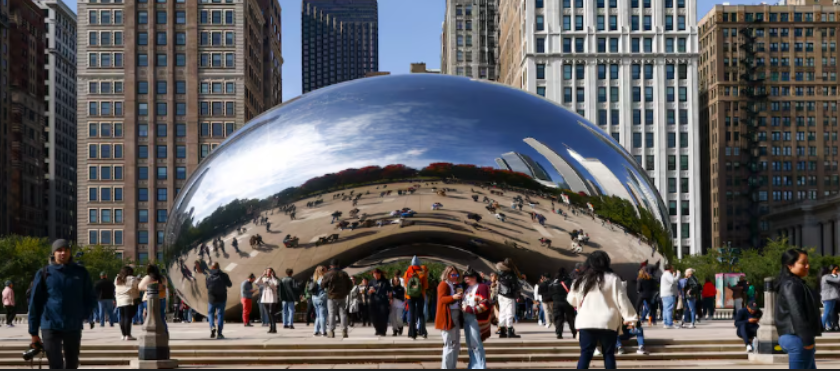

This notebook presents an **Exploratory Data Analysis** of the Chicago 311 [official public data](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data), with the goals of:
- understanding and describing the dataset's main characteristics and behavioral patterns;
- provide analytical support for downstream modeling [notebooks]()

---

## **Context**



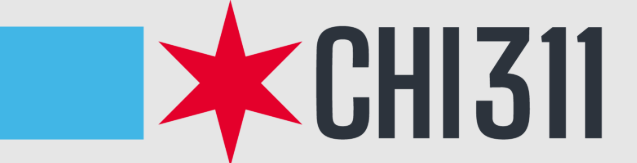

The **[Chicago 311 - Service Requests](https://311.chicago.gov/s/?language=en_US)** is the City of Chicago’s official system for **non-emergency service requests**. 

It provides a single access point for residents, businesses, and visitors to *interact with city services*.

**Main purposes**
- Centralize citizen–city communication  
- Reduce load on emergency services (911)  
- Improve transparency and accountability
- Direct back-up facility for 911  

---

### **How it works**

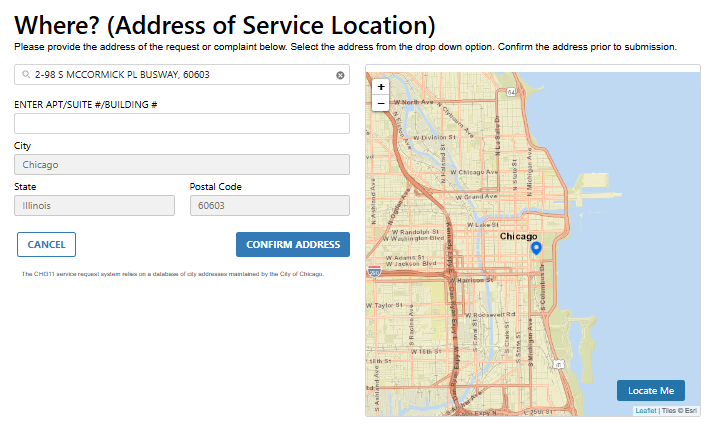

- Service Requests are submitted through different official channels
- Service Requests are routed to the correct city department  
- Service Requests status and updates are informed

---

### **Service examples**

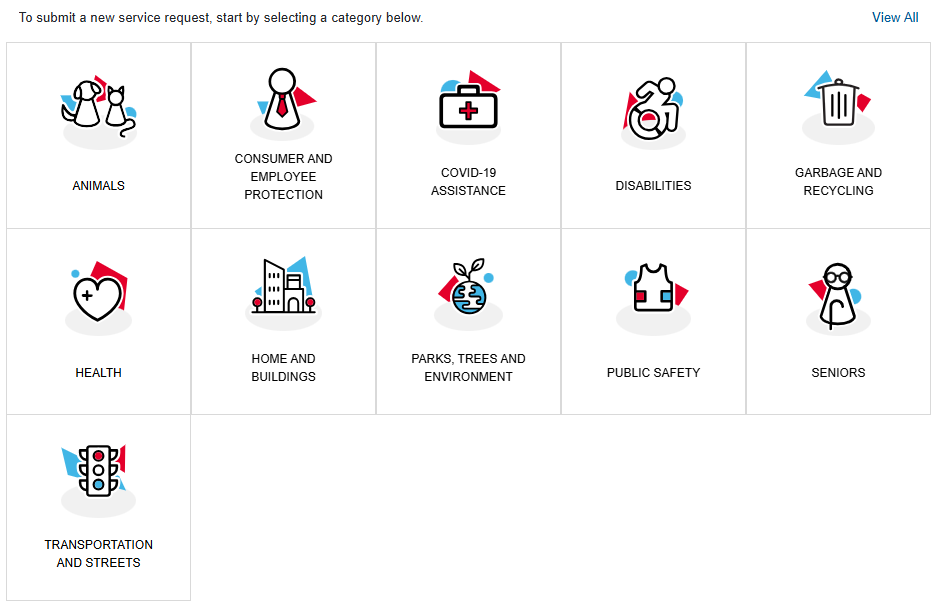

---

### **Data Value**

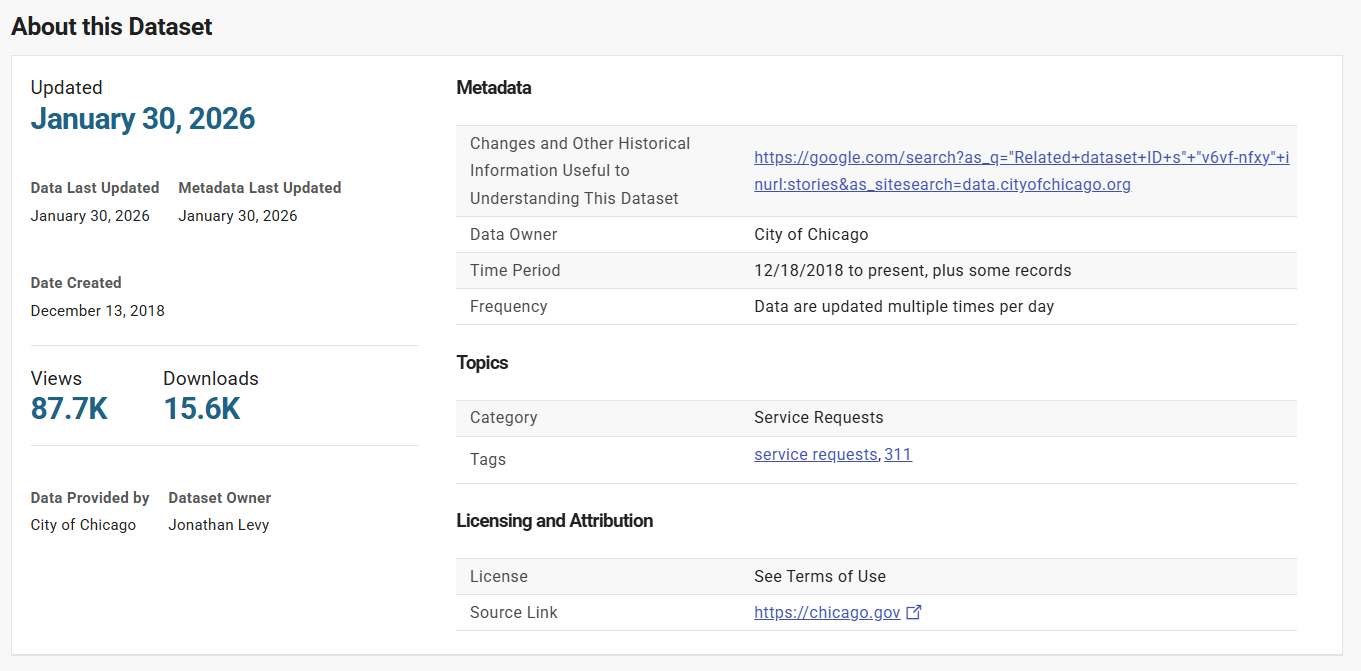

- High-volume, high-quality, spatial and time-stamped records  
- Reflects real urban demand  
- **[Daily Updated](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data)** -> will be used in a future **[ML Engineering Project]()**




### **Data Context**

---


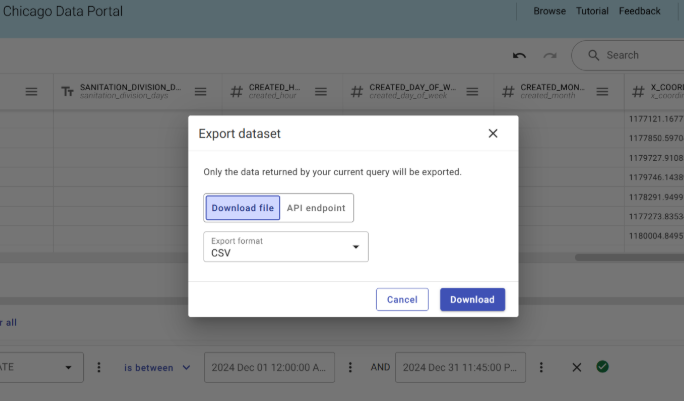

- Data is available via file downloads and an API; **direct CSV downloads** were used for reproducibility.
- **Three years of data** were merged and converted into a **single Parquet file (~7.6M records)**.
- Due to dataset size, **pandas-based EDA can be slow or unstable**.
- **DuckDB with SQL and sampling** is used to enable fast, interactive exploration while preserving representativeness.
- Data ingestion and engineering steps are **out of scope** for this notebook.


## **Preparation**

### **Setting up**

In [1]:
# Importing Python libraries
import numpy as np
from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geoviews as gv
import cartopy.crs as ccrs
from holoviews.operation.datashader import datashade
from colorcet import fire


In [2]:
# Initialize DuckDB database
con = duckdb.connect() 

### **Loading the Data**

In [3]:
# Preview
# Sample dataset (random seeds)
df_sample = con.execute("""
SELECT *
FROM 'data/processed/data.parquet'
USING SAMPLE 1% -- random sample seeds
""").df()

df_sample

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,CREATED_DEPARTMENT,OWNER_DEPARTMENT,STATUS,ORIGIN,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,...,SANITATION_DIVISION_DAYS,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,__index_level_0__
0,SR24-01238333,Street Light Out Complaint,SFD,None,CDOT - Department of Transportation,Completed,Internet,2024-07-01 18:29:07,2024-07-09 08:53:12,2024-07-09 08:53:12,...,None,18,2,7,"1128315,3061755935","1939596,8784492963","41,99057100094","-87,8034015","(41.990571000940825, -87.80340150000191)",294912
1,SR24-01238334,Aircraft Noise Complaint,AVN,311 City Services,Aviation,Completed,Phone Call,2024-07-01 18:29:10,2024-07-01 18:31:32,2024-07-01 18:29:11,...,None,18,2,7,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",294913
2,SR24-01238335,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2024-07-01 18:29:13,2024-07-01 18:31:32,2024-07-01 18:29:13,...,None,18,2,7,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",294914
3,SR24-01238336,Fly Dumping Complaint,SDR,311 City Services,Streets and Sanitation,Completed,Phone Call,2024-07-01 18:29:15,2024-07-03 16:03:29,2024-07-03 16:03:29,...,None,18,2,7,"1150043,4596670647","1911118,7256330962","41,91202800094","-87,724224","(41.91202800094055, -87.72422400000191)",294915
4,SR24-01238337,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2024-07-01 18:29:18,2024-07-01 18:31:16,2024-07-01 18:29:18,...,None,18,2,7,"1105376,7673561182","1941043,7883293368","41,99490000094","-87,8877495","(41.99490000094086, -87.8877495000019)",294916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63483,SR25-02331049,Water Lead Test Kit Request,WCA2,None,DWM - Department of Water Management,Open,DWM,2025-12-21 04:01:01,2025-12-30 12:15:24,None,...,None,4,1,12,"1160979,630222653","1865164,2713055294","41,78570400094","-87,6853215","(41.78570400094, -87.685321500002)",8127970
63484,SR25-02331050,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-12-21 04:01:11,2025-12-21 04:31:42,2025-12-21 04:01:11,...,None,4,1,12,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",8127971
63485,SR25-02331051,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-12-21 04:01:13,2025-12-21 04:31:35,2025-12-21 04:01:13,...,None,4,1,12,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",8127972
63486,SR25-02331053,Water Lead Test Kit Request,WCA2,None,DWM - Department of Water Management,Open,DWM,2025-12-21 04:01:25,2025-12-30 12:15:27,None,...,None,4,1,12,"1135608,5437584731","1933670,673142805","41,97418200094","-87,7767165","(41.974182000941, -87.776716500002)",8127973


### **Preprocessing**

In [4]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].info()

#  Type review
# 0   SR_NUMBER           object ✅
# 1   SR_TYPE             object ✅
# 2   SR_SHORT_CODE       object ✅
# 3   CREATED_DEPARTMENT  object ✅
# 4   OWNER_DEPARTMENT    object ✅
# 5   STATUS              object ✅
# 6   ORIGIN              object ✅
# 7   CREATED_DATE        object -> datetype ✅
# 8   LAST_MODIFIED_DATE  object -> datetype ✅
# 9   CLOSED_DATE         object -> datetype ✅

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63488 entries, 0 to 63487
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SR_NUMBER           63488 non-null  object
 1   SR_TYPE             63488 non-null  object
 2   SR_SHORT_CODE       63488 non-null  object
 3   CREATED_DEPARTMENT  37248 non-null  object
 4   OWNER_DEPARTMENT    63488 non-null  object
 5   STATUS              63488 non-null  object
 6   ORIGIN              63488 non-null  object
 7   CREATED_DATE        63488 non-null  object
 8   LAST_MODIFIED_DATE  63488 non-null  object
 9   CLOSED_DATE         62532 non-null  object
dtypes: object(10)
memory usage: 4.8+ MB


In [5]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].head()

# Wrong type for date columns

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,CREATED_DEPARTMENT,OWNER_DEPARTMENT,STATUS,ORIGIN,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE
0,SR24-01238333,Street Light Out Complaint,SFD,None,CDOT - Department of Transportation,Completed,Internet,2024-07-01 18:29:07,2024-07-09 08:53:12,2024-07-09 08:53:12
1,SR24-01238334,Aircraft Noise Complaint,AVN,311 City Services,Aviation,Completed,Phone Call,2024-07-01 18:29:10,2024-07-01 18:31:32,2024-07-01 18:29:11
2,SR24-01238335,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2024-07-01 18:29:13,2024-07-01 18:31:32,2024-07-01 18:29:13
3,SR24-01238336,Fly Dumping Complaint,SDR,311 City Services,Streets and Sanitation,Completed,Phone Call,2024-07-01 18:29:15,2024-07-03 16:03:29,2024-07-03 16:03:29
4,SR24-01238337,Aircraft Noise Complaint,AVN,None,Aviation,Completed,Internet,2024-07-01 18:29:18,2024-07-01 18:31:16,2024-07-01 18:29:18


In [6]:
# Fixing types (1/4)

# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data AS
SELECT
    * REPLACE (
        CREATED_DATE      ::TIMESTAMP AS CREATED_DATE,
        LAST_MODIFIED_DATE::TIMESTAMP AS LAST_MODIFIED_DATE,
        CLOSED_DATE       ::TIMESTAMP AS CLOSED_DATE
        )
FROM 'data/processed/data.parquet';
""")

# Update preview
df_sample = con.execute("""
SELECT *
FROM data
USING SAMPLE 1%
""").df()

# Pandas preview
df_sample[df_sample.columns[0:10]].info()   

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88064 entries, 0 to 88063
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SR_NUMBER           88064 non-null  object        
 1   SR_TYPE             88064 non-null  object        
 2   SR_SHORT_CODE       88064 non-null  object        
 3   CREATED_DEPARTMENT  51550 non-null  object        
 4   OWNER_DEPARTMENT    88064 non-null  object        
 5   STATUS              88064 non-null  object        
 6   ORIGIN              88064 non-null  object        
 7   CREATED_DATE        88064 non-null  datetime64[us]
 8   LAST_MODIFIED_DATE  88064 non-null  datetime64[us]
 9   CLOSED_DATE         86608 non-null  datetime64[us]
dtypes: datetime64[us](3), object(7)
memory usage: 6.7+ MB


In [7]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].info()

#  Type review
# 0   STREET_ADDRESS    object ✅
# 1   CITY              object ✅
# 2   STATE             object ✅
# 3   ZIP_CODE          object ✅
# 4   STREET_NUMBER     object ✅
# 5   STREET_DIRECTION  object ✅
# 6   STREET_NAME       object ✅
# 7   STREET_TYPE       object ✅
# 8   DUPLICATE         object -> boolean ✅
# 9   LEGACY_RECORD     object -> boolean ✅

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88064 entries, 0 to 88063
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   STREET_ADDRESS    88020 non-null  object
 1   CITY              69799 non-null  object
 2   STATE             69799 non-null  object
 3   ZIP_CODE          76358 non-null  object
 4   STREET_NUMBER     88004 non-null  object
 5   STREET_DIRECTION  87997 non-null  object
 6   STREET_NAME       88020 non-null  object
 7   STREET_TYPE       87314 non-null  object
 8   DUPLICATE         88064 non-null  object
 9   LEGACY_RECORD     88064 non-null  object
dtypes: object(10)
memory usage: 6.7+ MB


In [8]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].head()

# 'DUPLICATE' and 'LEGACY_RECORDS' are boolean values

,STREET_ADDRESS,CITY,STATE,ZIP_CODE,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,DUPLICATE,LEGACY_RECORD
0,2111 W Lexington ST,Chicago,Illinois,60612.0,2111,W,Lexington,ST,False,False
1,10510 W ZEMKE RD,Chicago,Illinois,60666.0,10510,W,ZEMKE,RD,False,False
2,5301 N LUDLAM AVE,Chicago,Illinois,60630.0,5301,N,LUDLAM,AVE,False,False
3,2111 W Lexington ST,Chicago,Illinois,60612.0,2111,W,Lexington,ST,False,False
4,10510 W ZEMKE RD,Chicago,Illinois,60666.0,10510,W,ZEMKE,RD,False,False


In [9]:
# Fixing types (2/4)

# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data_2 AS
SELECT
    * REPLACE(
        LOWER(DUPLICATE)     = 'true' AS DUPLICATE,
        LOWER(LEGACY_RECORD) = 'true' AS LEGACY_RECORD
        )
FROM data;
""")

# Update preview
df_sample = con.execute("""
SELECT *
FROM data_2
USING SAMPLE 1%
""").df()

# Pandas preview
df_sample[df_sample.columns[10:20]].info()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79872 entries, 0 to 79871
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   STREET_ADDRESS    79842 non-null  object
 1   CITY              63713 non-null  object
 2   STATE             63713 non-null  object
 3   ZIP_CODE          70336 non-null  object
 4   STREET_NUMBER     79841 non-null  object
 5   STREET_DIRECTION  79838 non-null  object
 6   STREET_NAME       79842 non-null  object
 7   STREET_TYPE       78840 non-null  object
 8   DUPLICATE         79872 non-null  bool  
 9   LEGACY_RECORD     79872 non-null  bool  
dtypes: bool(2), object(8)
memory usage: 5.0+ MB


In [10]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].info()

#  Type review
# 0   LEGACY_SR_NUMBER     object ✅
# 1   PARENT_SR_NUMBER     object ✅
# 2   COMMUNITY_AREA       object -> Int64 ✅
# 3   WARD                 object -> Int64 ✅
# 4   ELECTRICAL_DISTRICT  object -> Int64 ✅
# 5   ELECTRICITY_GRID     object ✅
# 6   POLICE_SECTOR        object -> Int64 ✅
# 7   POLICE_DISTRICT      object -> Int64 ✅
# 8   POLICE_BEAT          object -> Int64 ✅
# 9   PRECINCT             object -> Int64 ✅

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79872 entries, 0 to 79871
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   LEGACY_SR_NUMBER     0 non-null      object
 1   PARENT_SR_NUMBER     3188 non-null   object
 2   COMMUNITY_AREA       79805 non-null  object
 3   WARD                 79805 non-null  object
 4   ELECTRICAL_DISTRICT  19274 non-null  object
 5   ELECTRICITY_GRID     67222 non-null  object
 6   POLICE_SECTOR        79806 non-null  object
 7   POLICE_DISTRICT      79806 non-null  object
 8   POLICE_BEAT          79806 non-null  object
 9   PRECINCT             79787 non-null  object
dtypes: object(10)
memory usage: 6.1+ MB


In [11]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].head()

# Some colunes are Integers

,LEGACY_SR_NUMBER,PARENT_SR_NUMBER,COMMUNITY_AREA,WARD,ELECTRICAL_DISTRICT,ELECTRICITY_GRID,POLICE_SECTOR,POLICE_DISTRICT,POLICE_BEAT,PRECINCT
0,None,None,10.0,41.0,1.0,X107,1.0,16.0,1612.0,18.0
1,None,None,28.0,28.0,7.0,K024,2.0,12.0,1225.0,46.0
2,None,None,68.0,17.0,11.0,N039,3.0,7.0,733.0,28.0
3,None,None,28.0,28.0,7.0,K024,2.0,12.0,1225.0,46.0
4,None,None,28.0,28.0,7.0,K024,2.0,12.0,1225.0,46.0


In [12]:
# Preview (3/4)
df_sample[['COMMUNITY_AREA', 'WARD', 'ELECTRICAL_DISTRICT', 'POLICE_SECTOR', 'POLICE_DISTRICT', 'POLICE_BEAT', 'PRECINCT']]

# All integers

,COMMUNITY_AREA,WARD,ELECTRICAL_DISTRICT,POLICE_SECTOR,POLICE_DISTRICT,POLICE_BEAT,PRECINCT
0,10.0,41.0,1.0,1.0,16.0,1612.0,18.0
1,28.0,28.0,7.0,2.0,12.0,1225.0,46.0
2,68.0,17.0,11.0,3.0,7.0,733.0,28.0
3,28.0,28.0,7.0,2.0,12.0,1225.0,46.0
4,28.0,28.0,7.0,2.0,12.0,1225.0,46.0
...,...,...,...,...,...,...,...
79867,51.0,10.0,15.0,3.0,4.0,431.0,6.0
79868,76.0,41.0,None,5.0,16.0,1654.0,27.0
79869,76.0,41.0,None,5.0,16.0,1654.0,27.0
79870,28.0,28.0,7.0,2.0,12.0,1225.0,46.0


In [13]:
# Fixing types (3/4)

# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data_3 AS
SELECT
    * REPLACE(
        COMMUNITY_AREA      ::BIGINT AS COMMUNITY_AREA,
        WARD                ::BIGINT AS WARD,
        ELECTRICAL_DISTRICT ::BIGINT AS ELECTRICAL_DISTRICT,
        POLICE_SECTOR       ::BIGINT AS POLICE_SECTOR,
        POLICE_DISTRICT     ::BIGINT AS POLICE_DISTRICT,
        POLICE_BEAT         ::BIGINT AS POLICE_BEAT,
        PRECINCT            ::BIGINT AS PRECINCT
        )
FROM data_2;
""")

# Update preview
df_sample = con.execute("""
SELECT *
FROM data_3
USING SAMPLE 1%
""").df()

# Pandas preview
df_sample[df_sample.columns[20:30]].info()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69632 entries, 0 to 69631
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   LEGACY_SR_NUMBER     0 non-null      object
 1   PARENT_SR_NUMBER     3055 non-null   object
 2   COMMUNITY_AREA       69580 non-null  Int64 
 3   WARD                 69580 non-null  Int64 
 4   ELECTRICAL_DISTRICT  19560 non-null  Int64 
 5   ELECTRICITY_GRID     57040 non-null  object
 6   POLICE_SECTOR        69585 non-null  Int64 
 7   POLICE_DISTRICT      69585 non-null  Int64 
 8   POLICE_BEAT          69585 non-null  Int64 
 9   PRECINCT             69557 non-null  Int64 
dtypes: Int64(7), object(3)
memory usage: 5.8+ MB


In [14]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69632 entries, 0 to 69631
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   SANITATION_DIVISION_DAYS  0 non-null      object
 1   CREATED_HOUR              69632 non-null  object
 2   CREATED_DAY_OF_WEEK       69632 non-null  object
 3   CREATED_MONTH             69632 non-null  object
 4   X_COORDINATE              69606 non-null  object
 5   Y_COORDINATE              69606 non-null  object
 6   LATITUDE                  69605 non-null  object
 7   LONGITUDE                 69605 non-null  object
 8   LOCATION                  69605 non-null  object
 9   __index_level_0__         69632 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 5.3+ MB


In [15]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]].info()

#  Type review
# 0   SANITATION_DIVISION_DAYS  object -> drop    ✅
# 1   CREATED_HOUR              object -> Int64   ✅
# 2   CREATED_DAY_OF_WEEK       object -> Int64   ✅
# 3   CREATED_MONTH             object -> Int64   ✅
# 4   X_COORDINATE              object -> Float64 ✅
# 5   Y_COORDINATE              object -> Float64 ✅
# 6   LATITUDE                  object -> Float64 ✅
# 7   LONGITUDE                 object -> Float64 ✅
# 8   LOCATION                  object ✅

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69632 entries, 0 to 69631
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   SANITATION_DIVISION_DAYS  0 non-null      object
 1   CREATED_HOUR              69632 non-null  object
 2   CREATED_DAY_OF_WEEK       69632 non-null  object
 3   CREATED_MONTH             69632 non-null  object
 4   X_COORDINATE              69606 non-null  object
 5   Y_COORDINATE              69606 non-null  object
 6   LATITUDE                  69605 non-null  object
 7   LONGITUDE                 69605 non-null  object
 8   LOCATION                  69605 non-null  object
 9   __index_level_0__         69632 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 5.3+ MB


In [16]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]]

,SANITATION_DIVISION_DAYS,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,__index_level_0__
0,None,22,3,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",57344
1,None,22,3,11,"1183729,8235811417","1876973,6174387408","41,81760900094","-87,6015405","(41.81760900094, -87.601540500002)",57345
2,None,22,3,11,"1132512,5559813166","1936363,1327572586","41,98162500094","-87,7880385","(41.981625000941, -87.788038500002)",57346
3,None,22,3,11,"1172869,0723872976","1881699,1733102764","41,83082326863","-87,64124102781","(41.830823268628, -87.641241027808)",57347
4,None,22,3,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",57348
...,...,...,...,...,...,...,...,...,...,...
69627,None,14,3,12,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",8031714
69628,None,14,3,12,"1139578,2113136973","1925966,3714186533","41,95296900094","-87,7623075","(41.952969000941, -87.762307500002)",8031715
69629,None,14,3,12,"1172144,764315718","1826282,6638171016","41,67876926863","-87,64552406862","(41.678769268626, -87.645524068619)",8031716
69630,None,14,3,12,"1149054,5587567026","1886667,7657432987","41,84495100094","-87,72849","(41.84495100094, -87.728490000002)",8031717


In [17]:
# Preview (4/4)
df_sample['SANITATION_DIVISION_DAYS'].unique()[:10] # Empty 

array([None], dtype=object)

In [18]:
# Excluding 'SANITATION_DIVISION_DAYS' column
con.execute("""
CREATE OR REPLACE VIEW data_4 AS
SELECT *
EXCLUDE (SANITATION_DIVISION_DAYS)
FROM data_3;
""")

# Update preview
df_sample = con.execute("""
SELECT *
FROM data_4
USING SAMPLE 1%
""").df()

df_sample

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,CREATED_DEPARTMENT,OWNER_DEPARTMENT,STATUS,ORIGIN,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,...,PRECINCT,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION,__index_level_0__
0,SR25-02192194,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-11-29 10:26:36,2025-11-29 10:31:27,2025-11-29 10:26:37,...,46,10,7,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",147456
1,SR25-02192195,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-11-29 10:26:40,2025-11-29 10:30:39,2025-11-29 10:26:41,...,46,10,7,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",147457
2,SR25-02192196,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-11-29 10:26:46,2025-11-29 10:31:36,2025-11-29 10:26:46,...,46,10,7,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",147458
3,SR25-02192197,Building Violation,BBA,311 City Services,DOB - Buildings,Completed,Phone Call,2025-11-29 10:26:49,2025-12-05 16:49:01,2025-12-05 16:48:54,...,30,10,7,11,"1169701,7363725752","1860269,3846901548","41,77208700094","-87,653484","(41.77208700094, -87.653484000002)",147459
4,SR25-02192198,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-11-29 10:26:51,2025-11-29 10:31:36,2025-11-29 10:26:52,...,46,10,7,11,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",147460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73723,SR25-00986752,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-06-11 15:51:30,2025-06-11 16:32:46,2025-06-11 15:51:31,...,46,15,4,6,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",7468560
73724,SR25-00986755,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-06-11 15:51:42,2025-06-11 16:32:27,2025-06-11 15:51:43,...,46,15,4,6,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",7468561
73725,SR25-00986757,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-06-11 15:51:56,2025-06-11 16:33:05,2025-06-11 15:51:57,...,46,15,4,6,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",7468562
73726,SR25-00986758,311 INFORMATION ONLY CALL,311IOC,311 City Services,311 City Services,Completed,Phone Call,2025-06-11 15:52:01,2025-06-11 16:32:27,2025-06-11 15:52:01,...,46,15,4,6,"1162234,4668753312","1896560,9616219066","41,87183400094","-87,679845","(41.87183400094, -87.679845000002)",7468563


In [19]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]].info()

#  Type review
# 0   CREATED_HOUR         10000 non-null  object -> int64 ✅
# 1   CREATED_DAY_OF_WEEK  10000 non-null  object -> int64 ✅
# 2   CREATED_MONTH        10000 non-null  object -> int64 ✅
# 3   X_COORDINATE         9997 non-null   object -> float64 ✅
# 4   Y_COORDINATE         9997 non-null   object -> float64 ✅
# 5   LATITUDE             9997 non-null   object -> float64 ✅
# 6   LONGITUDE            9997 non-null   object -> float64 ✅
# 7   LOCATION             9997 non-null   object ✅

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73728 entries, 0 to 73727
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CREATED_HOUR         73728 non-null  object
 1   CREATED_DAY_OF_WEEK  73728 non-null  object
 2   CREATED_MONTH        73728 non-null  object
 3   X_COORDINATE         73693 non-null  object
 4   Y_COORDINATE         73693 non-null  object
 5   LATITUDE             73692 non-null  object
 6   LONGITUDE            73692 non-null  object
 7   LOCATION             73692 non-null  object
 8   __index_level_0__    73728 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 5.1+ MB


In [20]:
# Fixing types (4/4)

# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data_5 AS
SELECT 
    * REPLACE(
        CREATED_HOUR                               ::BIGINT AS CREATED_HOUR,
        CREATED_DAY_OF_WEEK                        ::BIGINT AS CREATED_DAY_OF_WEEK,
        CREATED_MONTH                              ::BIGINT AS CREATED_MONTH,
        regexp_replace(X_COORDINATE, ',', '.', 'g')::DOUBLE AS X_COORDINATE,
        regexp_replace(Y_COORDINATE, ',', '.', 'g')::DOUBLE AS Y_COORDINATE,
        regexp_replace(LATITUDE,     ',', '.', 'g')::DOUBLE AS LATITUDE,
        regexp_replace(LONGITUDE,    ',', '.', 'g')::DOUBLE AS LONGITUDE    
            
            
            )
FROM data_4;
""")

# Update preview
df_sample = con.execute("""
SELECT *
FROM data_5
USING SAMPLE 1%
""").df()

# Pandas preview
df_sample[df_sample.columns[30:40]].info()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49152 entries, 0 to 49151
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CREATED_HOUR         49152 non-null  int64  
 1   CREATED_DAY_OF_WEEK  49152 non-null  int64  
 2   CREATED_MONTH        49152 non-null  int64  
 3   X_COORDINATE         49139 non-null  float64
 4   Y_COORDINATE         49139 non-null  float64
 5   LATITUDE             49137 non-null  float64
 6   LONGITUDE            49137 non-null  float64
 7   LOCATION             49137 non-null  object 
 8   __index_level_0__    49152 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 3.4+ MB


## **Exploratory Data Analysis**

#### **Structure Overview**

In [21]:
# Shape
con.execute("""SELECT * FROM data_5""").df().shape # read and discard the object

# 7645761 rows x 39 columns

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(7645761, 39)

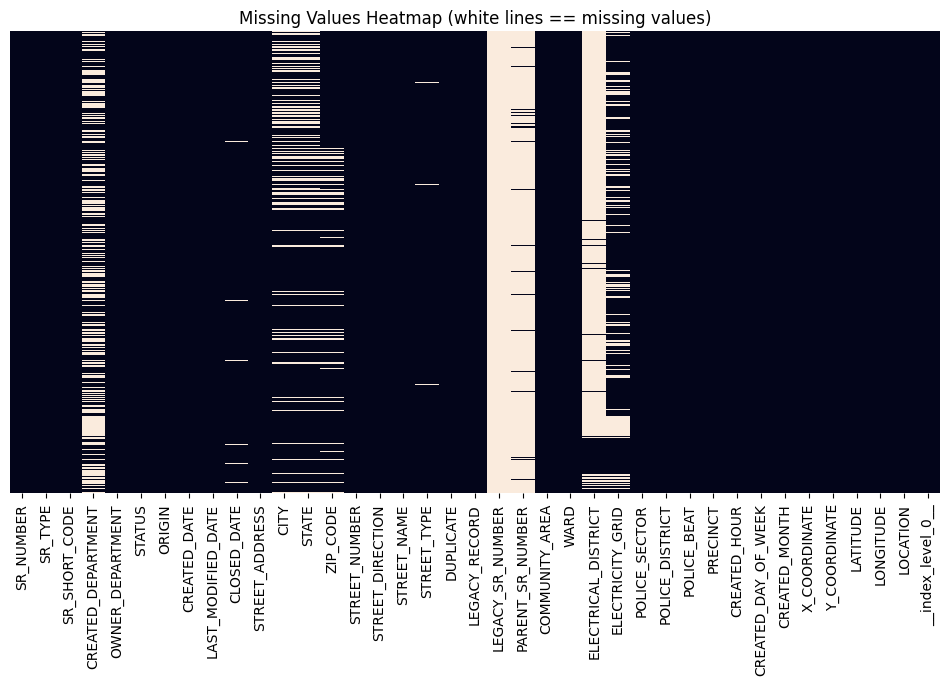

In [22]:
# Vizualizing missing data with sampling
df_sample = df_sample.sort_values("CREATED_DATE")
plt.figure(figsize=(12, 6))
sns.heatmap(df_sample.isna(),cbar=False,yticklabels=False)
plt.title('Missing Values Heatmap (white lines == missing values)')
plt.show()

# white lines -> missing values

In [23]:
# High missingess %
(df_sample.isna().mean().sort_values(ascending=False).head(25)*100).round(decimals=2)


# High missingess columns:

# Unusable! (>60%)
# ==================
# LEGACY_SR_NUMBER
# PARENT_SR_NUMBER
# ELECTRICAL_DISTRICT

# "Repairable" if necessary
# ==================
# CREATED_DEPARTMENT
# STATE
# CITY
# ELETRICITY_GRID
# ZIP_CODE

LEGACY_SR_NUMBER       100.00
PARENT_SR_NUMBER        96.18
ELECTRICAL_DISTRICT     88.74
CREATED_DEPARTMENT      42.37
ELECTRICITY_GRID        20.23
CITY                    20.10
STATE                   20.10
ZIP_CODE                11.89
CLOSED_DATE              1.62
STREET_TYPE              0.88
PRECINCT                 0.13
COMMUNITY_AREA           0.10
POLICE_BEAT              0.09
POLICE_DISTRICT          0.09
POLICE_SECTOR            0.09
WARD                     0.09
STREET_DIRECTION         0.06
STREET_NUMBER            0.06
LOCATION                 0.03
LATITUDE                 0.03
LONGITUDE                0.03
STREET_NAME              0.03
STREET_ADDRESS           0.03
X_COORDINATE             0.03
Y_COORDINATE             0.03
dtype: float64

In [24]:
# Excluding columnS
con.execute("""
CREATE OR REPLACE VIEW data_6 AS
SELECT *
EXCLUDE(LEGACY_SR_NUMBER, PARENT_SR_NUMBER, ELECTRICAL_DISTRICT)
FROM data_5;
""")

df_sample = con.execute("""
SELECT *
FROM data_6
USING SAMPLE 1%
""").df()

(df_sample.isna().mean().sort_values(ascending=False).head(25)*100).round(decimals=2)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CREATED_DEPARTMENT    41.00
CITY                  19.70
STATE                 19.70
ELECTRICITY_GRID      18.99
ZIP_CODE               9.47
CLOSED_DATE            1.50
STREET_TYPE            0.82
PRECINCT               0.10
COMMUNITY_AREA         0.08
WARD                   0.07
POLICE_DISTRICT        0.07
POLICE_BEAT            0.07
POLICE_SECTOR          0.07
STREET_DIRECTION       0.05
STREET_NUMBER          0.05
LONGITUDE              0.04
LOCATION               0.04
LATITUDE               0.04
Y_COORDINATE           0.04
X_COORDINATE           0.04
STREET_NAME            0.04
STREET_ADDRESS         0.04
SR_NUMBER              0.00
SR_TYPE                0.00
SR_SHORT_CODE          0.00
dtype: float64

#### **Categorical Columns Analysis**

In [25]:
con.execute("""
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'data_6'
  AND data_type = 'VARCHAR'
""").df()


# Our Focus:
# SR_TYPE
# CREATED_DEPARTMENT
# OWNER_DEPARTMENT
# STATUS	
# ORIGIN	
# CITY
# STATE

,column_name,data_type
0,SR_NUMBER,VARCHAR
1,SR_TYPE,VARCHAR
2,SR_SHORT_CODE,VARCHAR
3,CREATED_DEPARTMENT,VARCHAR
4,OWNER_DEPARTMENT,VARCHAR
5,STATUS,VARCHAR
6,ORIGIN,VARCHAR
7,STREET_ADDRESS,VARCHAR
8,CITY,VARCHAR
9,STATE,VARCHAR


##### **`SR_TYPE`**

In [26]:
# SR_TYPE top 20
(df_sample['SR_TYPE'].value_counts(normalize=True).sort_values(ascending=False)*100).round(decimals=2).head(20)

# Information only + Aircraft noise - dominate the distribution

SR_TYPE
311 INFORMATION ONLY CALL                       37.55
Aircraft Noise Complaint                        18.88
Graffiti Removal Request                         4.23
Pothole in Street Complaint                      3.07
Abandoned Vehicle Complaint                      2.74
Rodent Baiting/Rat Complaint                     2.61
Garbage Cart Maintenance                         2.38
Street Light Out Complaint                       2.11
Traffic Signal Out Complaint                     1.24
Tree Trim Request (NO LONGER BEING ACCEPTED)     1.15
Tree Debris Clean-Up Request                     1.08
Building Violation                               1.06
Blue Recycling Cart                              1.04
Dead Animal Pick-Up Request                      0.87
Tree Planting Request                            0.85
Tree Removal Inspection                          0.84
Sign Repair Request - All Other Signs            0.81
Tree Emergency                                   0.75
Water Lead Test Kit 

In [27]:
# Possible rare yet high SLA impact event examples
long_tail = con.execute("""
SELECT
    SR_TYPE,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2)         AS pct
FROM data_6
WHERE CREATED_DATE IS NOT NULL 
  AND CLOSED_DATE IS NOT NULL
  AND SR_TYPE NOT ILIKE '%tree%'                     
GROUP BY SR_TYPE
ORDER BY avg_days_open DESC, pct DESC
LIMIT 20;
          
                       """).df()

long_tail

# Tree-related requests dominate counts due to semantic grouping,
# so they are excluded to highlight other high-SLA-impact categories.

,SR_TYPE,avg_days_open,pct
0,Sidewalk Inspection Request,693.61,0.28
1,Shared Cost Sidewalk Program Request,655.79,0.05
2,Protected Bike Lane - Debris Removal,351.57,0.01
3,Viaduct Light Out Complaint,199.06,0.02
4,Sign Repair Request - All Other Signs,182.18,0.69
5,No Building Permit and Construction Violation,160.46,0.27
6,Bicycle Request/Complaint,153.49,0.04
7,Paid Sick Leave Violation,142.73,0.01
8,Licensed Pharmaceutical Representative Complaint,119.74,0.00
9,Wage Complaint,82.50,0.01


##### **`CREATED_DEPARTMENT`**

In [28]:
# SR_TYPE top 20
(df_sample['CREATED_DEPARTMENT'].value_counts(normalize=True).sort_values(ascending=False)*100).round(decimals=2).head(20)

# 311 City Services dominates the distribution

CREATED_DEPARTMENT
311 City Services                                  89.19
Alderman                                            4.63
CDOT - Department of Transportation                 3.16
Streets and Sanitation                              2.40
DWM - Department of Water Management                0.29
DOB - Buildings                                     0.15
BACP - Business Affairs and Consumer Protection     0.07
Animal Care and Control                             0.07
Health                                              0.02
Administrative Hearings                             0.01
Police                                              0.00
Name: proportion, dtype: float64

##### **`OWNER_DEPARTMENT`**

In [29]:
# SR_TYPE top 20
(df_sample['OWNER_DEPARTMENT'].value_counts(normalize=True).sort_values(ascending=False)*100).round(decimals=2).head(20)

# 311 City Services + Aviation - Still dominant
# Streets and Sanitation + CDOT - Appears with high frequency now (possibly after misplacement fix?)

OWNER_DEPARTMENT
311 City Services                                  37.55
Streets and Sanitation                             23.31
Aviation                                           18.88
CDOT - Department of Transportation                 9.97
DWM - Department of Water Management                3.89
Animal Care and Control                             2.28
DOB - Buildings                                     2.24
BACP - Business Affairs and Consumer Protection     0.66
Finance                                             0.53
Outside Agencies                                    0.27
City Clerk's Office                                 0.20
Health                                              0.19
Department of Housing                               0.03
Fire                                                0.02
Name: proportion, dtype: float64

##### **`STATUS`**

In [30]:
# SR_TYPE top 20
(df_sample['STATUS'].value_counts(normalize=True).sort_values(ascending=False)*100).round(decimals=2).head(20)

# >90% of requests are marked as "Completed".
# closure may be driven by automatic rules or operational workflows,
# which could bias SLA/time-to-close modeling and class imbalance.

STATUS
Completed    96.95
Canceled      1.55
Open          1.50
Name: proportion, dtype: float64

In [31]:
# Top Not completed
not_completed = con.execute("""
SELECT
    SR_TYPE,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2)         AS pct,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open                     
FROM data_6
WHERE CREATED_DATE IS NOT NULL 
  AND CLOSED_DATE IS NOT NULL
  AND STATUS != 'Completed'                                          
GROUP BY SR_TYPE
ORDER BY pct DESC, avg_days_open DESC
LIMIT 20;
                       """).df()

not_completed


# Stray Animal: unresolved/unsuccessful capture ?
# Water and Tree related categories dominate operational workload even outside "Completed".

,SR_TYPE,pct,avg_days_open
0,Stray Animal Complaint,23.85,9.37
1,Tree Debris Clean-Up Request,9.30,4.07
2,Tree Removal Inspection,7.27,77.58
3,Check for Leak,5.12,0.95
4,Water Lead Test Kit Request,4.74,14.25
5,No Water Complaint,4.08,0.14
6,Report an Injured Animal,4.03,0.69
7,Open Fire Hydrant Complaint,3.14,0.27
8,Water On Street Complaint,2.96,1.03
9,Water in Basement Complaint,2.78,1.02


##### **`ORIGIN`**

In [32]:
# SR_TYPE top 20
(df_sample['ORIGIN'].value_counts(normalize=True).sort_values(ascending=False)*100).round(decimals=2).head(20)

ORIGIN
Phone Call                    56.01
Internet                      29.36
Mobile Device                  8.64
Alderman's Office              2.95
Mass Entry                     1.80
SPOTCSR                        0.34
Salesforce Mobile App          0.29
DWM                            0.23
Generated In House             0.09
spot-open311-Chicago+Works     0.09
WOFromTerraGo                  0.06
City Department                0.03
spot-open311-SeeClickFix       0.03
E-Mail                         0.03
Mail                           0.02
Chicago Police Department      0.01
spot-open311-CHITEXT           0.01
Walk-in                        0.00
Phone                          0.00
Fax                            0.00
Name: proportion, dtype: float64

In [33]:
# Rare yet High impact events (long tail)
long_tail = con.execute("""
SELECT
    ORIGIN,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2)         AS pct
FROM data_6
WHERE CREATED_DATE IS NOT NULL 
  AND CLOSED_DATE IS NOT NULL                     
GROUP BY ORIGIN
ORDER BY avg_days_open DESC, pct DESC;
          
                       """).df()

long_tail

# Legacy methods are very slow yet very rare
# E-mail, though modern, is slow  and rare as mail
# Walking-in beats a State Representative by almost a week!
# A phone call is probably the most reliable way to register a complain!

,ORIGIN,avg_days_open,pct
0,Fax,86.24,0.00
1,Mail,63.46,0.00
2,E-Mail,63.29,0.03
3,Open311 Interface,56.67,0.00
4,spot-open311-Chicago+Works,48.68,0.06
5,Alderman's Office,47.42,3.36
6,State Representatives,41.85,0.00
7,spot-open311-SeeClickFix,35.98,0.03
8,DWM,35.49,0.24
9,Walk-in,35.23,0.01


#### **Time/Date Columns Analysis**

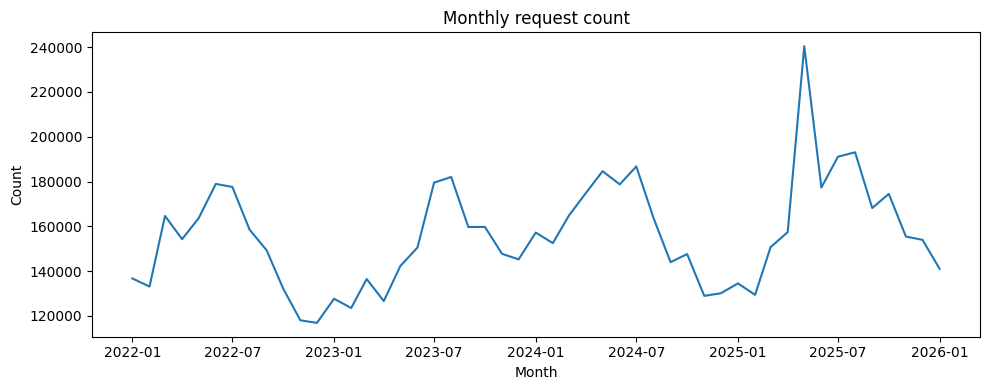

In [34]:
df_month = con.execute("""
SELECT
    DATE_TRUNC('month', CREATED_DATE) AS month,
    COUNT(*) AS n
FROM data_6
GROUP BY 1
ORDER BY 1
""").df()

plt.figure(figsize=(10,4))
plt.plot(df_month["month"], df_month["n"])
plt.title("Monthly request count")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Series shows higher counts in the middle of the year 
# Lower counts at the start/end of the year 
# Might indicates sazonality
# Annual maximum and minimum counts have been increasing since 2022

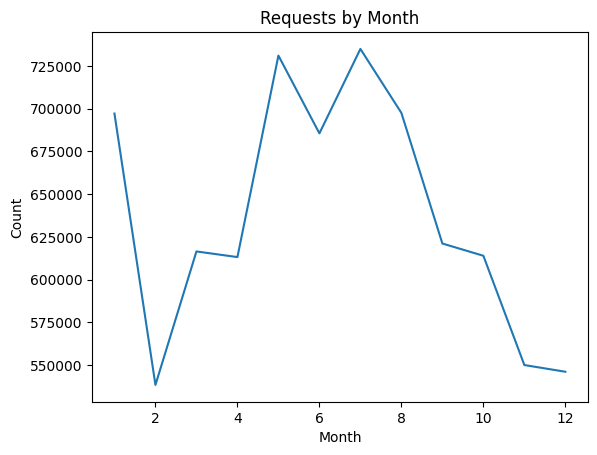

In [35]:
# Requests by month
df_month = con.execute("""
SELECT CREATED_MONTH, COUNT(*) AS n
FROM data_6
GROUP BY CREATED_MONTH
ORDER BY CREATED_MONTH
""").df()

df_month.plot(x="CREATED_MONTH", y="n", legend=False)
plt.title("Requests by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

# November to February -> lowest requests counts
# May to August        -> highest requests counts

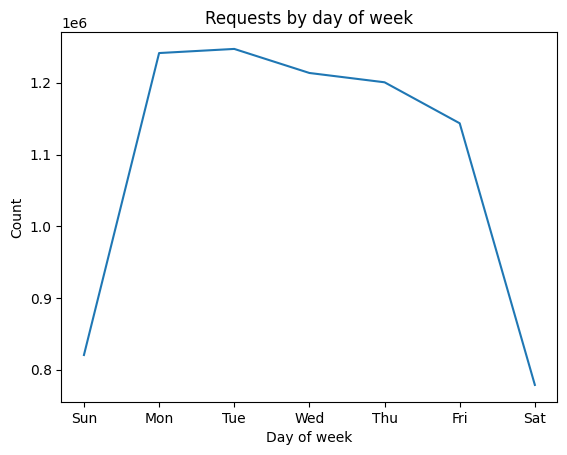

In [36]:
# Requests by day of week (1=Sunday ... 7=Saturday)
df_dow = con.execute("""
SELECT
    CREATED_DAY_OF_WEEK,
    COUNT(*) AS n
FROM data_6
GROUP BY 1
ORDER BY 1
""").df()

ax = df_dow.plot(x="CREATED_DAY_OF_WEEK", y="n", legend=False)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(["Sun","Mon","Tue","Wed","Thu","Fri","Sat"])

ax.set_title("Requests by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Count")
plt.show()

# Most of request volumes in work days

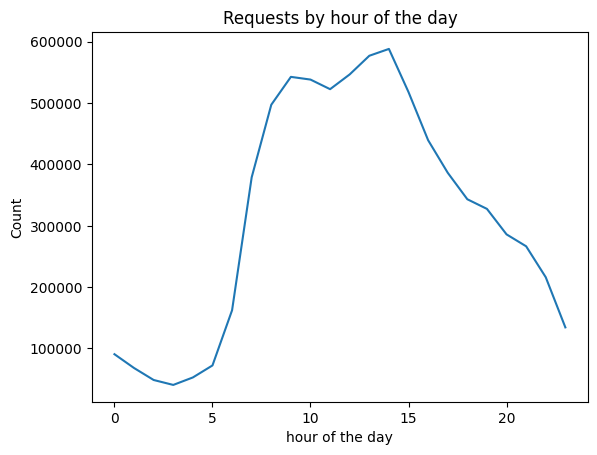

In [37]:
# Requests by hour of the day
df_hour = con.execute("""
SELECT CREATED_HOUR, COUNT(*) AS n
FROM data_6
GROUP BY CREATED_HOUR
ORDER BY CREATED_HOUR
""").df()

df_hour.plot(x="CREATED_HOUR", y="n", legend=False)
plt.title("Requests by hour of the day")
plt.xlabel("hour of the day")
plt.ylabel("Count")
plt.show()

# Most of requests in work hours

#### **Spatial Columns Analysis**

In [38]:
# % valid coordinates
stats = con.execute("""
SELECT
    COUNT(*) AS n_total,
    COUNT(*) FILTER (
        WHERE latitude  BETWEEN -90  AND 90
          AND longitude BETWEEN -180 AND 180
    ) AS n_valid
FROM data_6
""").df()

stats["pct_valid"] = stats["n_valid"] / stats["n_total"]
stats["pct_valid"]

# almost 100%

0    0.99945
Name: pct_valid, dtype: float64

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
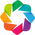

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'850aba03-cf2e-474c-a7cb-25275451dd43': {'version…

In [39]:
#
gv.extension("bokeh")

df = con.execute("""
SELECT latitude AS lat, longitude AS lon
FROM data_6
WHERE latitude IS NOT NULL
  AND longitude IS NOT NULL
""").df()

(
    gv.tile_sources.CartoDark()
    * datashade(
        gv.Points(df, ["lon", "lat"]),
        cmap="fire",              
        width=600,
        height=600,
        expand=False
    )
).opts(width=400, height=400)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
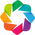

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'1ea1605e-ae75-4198-801c-d5da40fa004b': {'version…

In [40]:
# Service Requests Density
gv.extension("bokeh")

df = con.execute("""
SELECT latitude AS lat, longitude AS lon
FROM data_6
WHERE latitude IS NOT NULL
  AND longitude IS NOT NULL
""").df()

points = gv.Points(df, ["lon", "lat"])

shaded = datashade(
    points,
    width=1200,
    height=1200,
    cmap=fire,  
    cnorm='eq_hist'     
)

(gv.tile_sources.CartoDark * shaded).opts(width=400, height=400)

# Service requests are denser in the north, particularly along the central–northeast lakefront, 
# with a clear decline toward the south and higher activity along major arterial roads.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
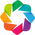

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'2cbe4e2e-419b-4399-acf7-0424f30619ef': {'version…

In [41]:


gv.extension("bokeh")

df = con.execute("""
SELECT
    longitude AS lon,
    latitude  AS lat,
    EXTRACT(EPOCH FROM (COALESCE(closed_date, now()) - created_date)) / 86400
        AS open_days
FROM data_6
WHERE latitude IS NOT NULL
  AND longitude IS NOT NULL
""").df()

# Non linearity
df["open_days"] = np.log1p(df["open_days"])

points = gv.Points(
    df,
    kdims=["lon", "lat"],
    vdims=["open_days"]
)

shaded = datashade(
    points,
    aggregator="mean",
    width=1200,
    height=1200,
    cmap=fire,
    cnorm="eq_hist",
    expand=False
)

(gv.tile_sources.CartoDark * shaded).opts(width=400, height=400)

# Service Request times are higher in the periphery—especially the south
# Northwest—while the center is handled faster.

#### **Column relationship analysis**

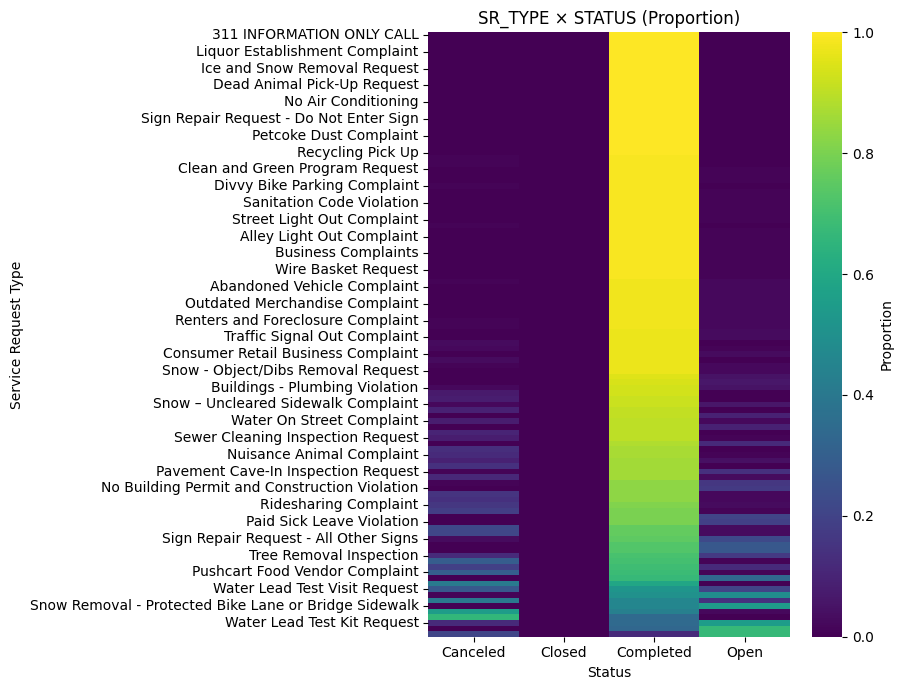

In [42]:
# SR_TYPE × STATUS — heatmap
df_SR_status = con.execute("""
SELECT
    SR_TYPE,
    STATUS,
    COUNT(*) AS n,
    COUNT(*) * 1.0
      / SUM(COUNT(*)) OVER (PARTITION BY SR_TYPE) AS pct
FROM data_6
GROUP BY SR_TYPE, STATUS
ORDER BY SR_TYPE, pct DESC
""").df()

df_SR_status["pct"] = df_SR_status["pct"].round(2)

# order by % Completed (ascending)
order = (
    df_SR_status[df_SR_status["STATUS"] == "Completed"]
    .sort_values("pct", ascending=False)["SR_TYPE"]
)

piv = (
    df_SR_status
    .pivot(index="SR_TYPE", columns="STATUS", values="pct")
    .loc[order]
    .fillna(0)
)

plt.figure(figsize=(9, 7))
sns.heatmap(
    piv,
    cmap="viridis",
    annot=False,
    fmt=".2f",
    cbar_kws={"label": "Proportion"}
)
plt.xlabel("Status")
plt.ylabel("Service Request Type")
plt.title("SR_TYPE × STATUS (Proportion)")
plt.tight_layout()
plt.show()

# many SR_TYPES are near-deterministic in outcome ('Completed') 
# this high predictability implies limited opportunities for modeling SR_STATUS.

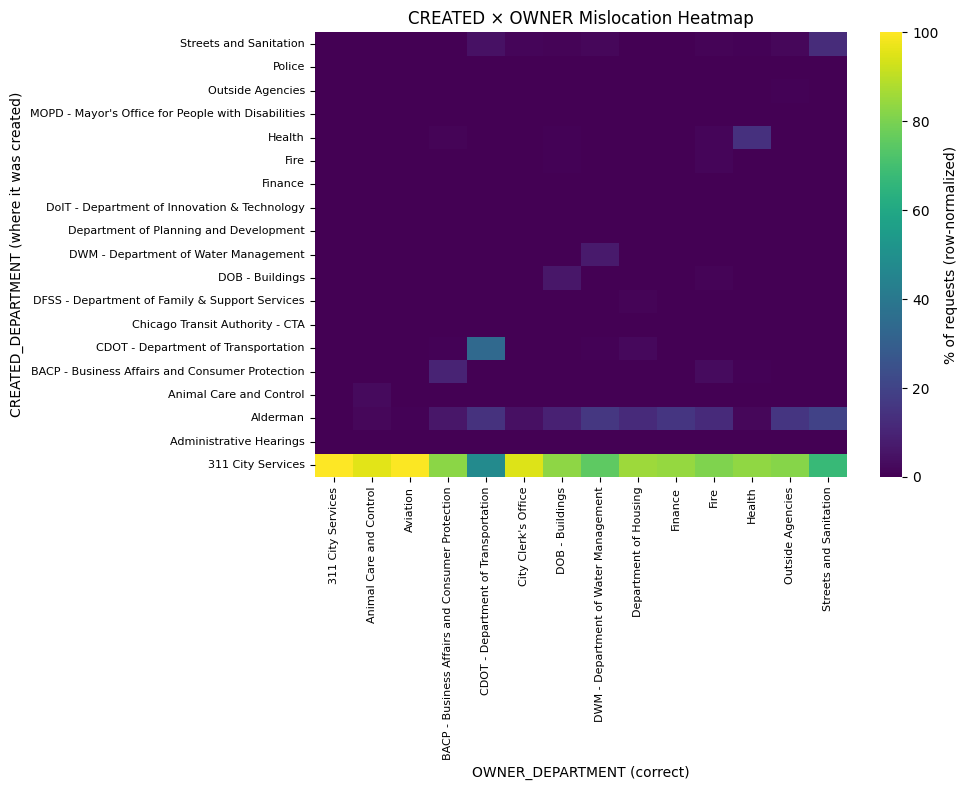

In [43]:
# CREATED × OWNER mislocation heatmap

df_hm = con.execute("""
WITH agg AS (
    SELECT
        OWNER_DEPARTMENT,
        CREATED_DEPARTMENT,
        COUNT(*) AS n
    FROM data_6
    WHERE OWNER_DEPARTMENT IS NOT NULL
      AND CREATED_DEPARTMENT IS NOT NULL
    GROUP BY 1, 2
),
tot AS (
    SELECT
        OWNER_DEPARTMENT,
        SUM(n) AS total_n
    FROM agg
    GROUP BY 1
),
mis AS (
    SELECT
        a.OWNER_DEPARTMENT,
        a.CREATED_DEPARTMENT,
        (a.n * 100.0) / t.total_n AS pct
    FROM agg a
    JOIN tot t
      ON a.OWNER_DEPARTMENT = t.OWNER_DEPARTMENT
),
mis_rate AS (
    SELECT
        OWNER_DEPARTMENT,
        SUM(
            CASE
                WHEN CREATED_DEPARTMENT <> OWNER_DEPARTMENT
                THEN pct ELSE 0
            END
        ) AS mis_pct
    FROM mis
    GROUP BY 1
)
SELECT
    m.OWNER_DEPARTMENT,
    m.CREATED_DEPARTMENT,
    m.pct
FROM mis m
JOIN mis_rate r
  ON m.OWNER_DEPARTMENT = r.OWNER_DEPARTMENT
ORDER BY r.mis_pct DESC
""").df()

piv = (
    df_hm
    .pivot(
        index="CREATED_DEPARTMENT",   # Y: where it was created
        columns="OWNER_DEPARTMENT",   # X: correct department
        values="pct"
    )
    .fillna(0)
    .round(1)
)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    piv,
    cmap="viridis",
    annot=False,
    cbar_kws={"label": "% of requests (row-normalized)"}
)

ax.set_xlabel("OWNER_DEPARTMENT (correct)")
ax.set_ylabel("CREATED_DEPARTMENT (where it was created)")
ax.set_title("CREATED × OWNER Mislocation Heatmap")
ax.invert_yaxis()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

# 311 and Alderman receives most of the complaints and direct them to the OWNER department

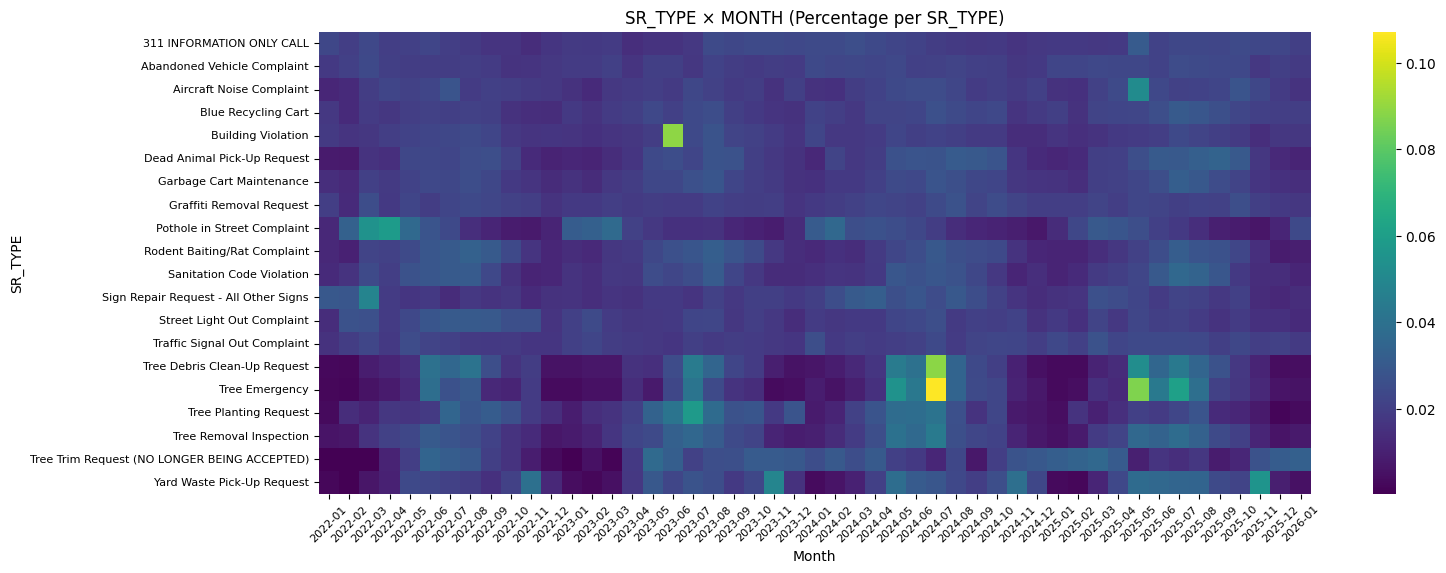

In [44]:
# SR_TYPE × MONTH — heatmap top 20
df = con.execute("""
WITH top_sr AS (
    SELECT SR_TYPE
    FROM data_6
    GROUP BY SR_TYPE
    ORDER BY COUNT(*) DESC
    LIMIT 20
)
SELECT
    d.SR_TYPE,
    STRFTIME(d.CREATED_DATE, '%Y-%m') AS month,
    COUNT(*) AS n
FROM data_6 d
JOIN top_sr t
  ON d.SR_TYPE = t.SR_TYPE
GROUP BY 1, 2
""").df()

# normalize per SR_TYPE (row sums to 1)
piv = (
    df
    .pivot(index="SR_TYPE", columns="month", values="n")
    .fillna(0)
)

piv = piv.div(piv.sum(axis=1), axis=0)

plt.figure(figsize=(16, max(6, 0.3 * len(piv))))
ax = sns.heatmap(
    piv,
    cmap="viridis",
    annot=False
)

ax.set_xlabel("Month")
ax.set_ylabel("SR_TYPE")
ax.set_title("SR_TYPE × MONTH (Percentage per SR_TYPE)")

ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
plt.show()

# Most SR types peak mid-year, consistent with the time-series results
# 'Pothole in the Street' shows an inverted seasonal pattern
# Several SR types exhibit no clear seasonality

In [45]:
con.execute("""
COPY data_6 TO 'eda.parquet' (FORMAT PARQUET);
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

##  **Key Insights**




### **Highly concentrated request distribution**
- A small subset of `SR_TYPE` categories accounts for most requests  
- Volume-based prioritization is insufficient

---

### **Long-tail categories drive high resolution times**
- Low-frequency SR types show  high average time-to-close  
- Though Long tail alone is not more relevant than head for SLA impact

---

### **Request status is near-deterministic**
- Over 90% of requests are marked as *Completed*  
- Many SR types could have almost deterministic outcomes  
- `STATUS` is weak as a predictive target

---

### **Clear temporal structure**
- Strong annual seasonality (mid-year peaks, winter lows)  
- Higher volume on weekdays  
- Requests concentrate during business hours

---

### **Spatial imbalance in performance**
- Higher request density in central–northern areas  
- Longer resolution times in southern and peripheral regions  
- Demand intensity and service performance are misaligned

---

### **Operational routing effects**
- Central intake channels (311, Alderman) dominate request creation  
- Requests are forwarded to specialized owner departments  
- Misallocation suggests routing inefficiencies

---

### **SR-type–specific seasonality**
- Most SR types peak mid-year  
- Some categories show inverted seasonal patterns  
- Others exhibit weak or no seasonality

---

### **High spatial data quality**
- Nearly all records contain valid coordinates  
- Minimal spatial missingness  
- Dataset supports reliable spatial and spatio-temporal analysis

## **Limitations & Assumptions**



### **Sampling-based analysis**
Exploration uses random sampling.  
Rare request types may be underrepresented.

---

### **Open vs. closed requests**
Resolution time exists only for closed requests.  
Open cases behave as censored observations.

---

### **Administrative categories**
`SR_TYPE` and departments are policy-defined labels.  
Patterns may reflect workflow rules.

---

### **Spatial accuracy**
Coordinates are assumed valid.  
Precision varies across records.

---

### **Missing external context**
No weather, infrastructure, or demographic data.  
Findings are descriptive, not causal.

---

### **Temporal aggregation**
Monthly and weekly aggregation smooths spikes.  
Short-term dynamics may be hidden.

---

### **Operational timestamps**
Time-to-close reflects system timestamps.  
Delays may be administrative.

## **Next Steps**






### Candidate models
- Tabular prediction: Logistic Regression, XGBoost, Catboost
- Ranking and prioritization: LambdaMART, LightGBM ranking  
- Segmentation: K-Means, Gaussian Mixture Models
- Causal: Meta Learner, Uplifttrees, Causal Forest  
- Forecasting: ARIMA/SARIMA, Prophet, Gradient Boosting  
- Risk / anomaly: Isolation Forest, Autoencoder, One-Class SVM  
- Inference

---

### Possible metrics
- Classification: ROC-AUC, PR-AUC, log loss  
- Ranking: NDCG@k, MAP@k  
- Forecasting: MAE, RMSE, MAPE  
- Segmentation: Silhouette score, stability across samples  
- Causal / uplift: Qini, AUUC  

---

### ML pipeline integration
- Deterministic feature generation (DuckDB / SQL-first)  
- Train–validation splits by time  
- Experiment tracking and model registry  
- Batch inference and periodic retraining  
- Monitoring: data drift, performance decay, alerting  
